# Modeling Choices

This notebook serves as an explanation of how rays are computed through the input files.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

In [3]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [4]:
UR = UltrasoundRenderer(128)

In [5]:
def generate_brain_phantom_2d(rows=20, cols=10) -> torch.Tensor:
    brain = 1.60e6
    tumor = 1.68e6
    csf = 1.50e6
    bone = 7.80e6
    air = 0.0004e6

    phantom = torch.full((rows, cols), air)  # default: outside air

    # Make elliptical brain mask
    yy, xx = torch.meshgrid(torch.linspace(-1, 1, rows), torch.linspace(-1, 1, cols), indexing='ij')
    brain_mask = (xx**2 / 0.8**2 + yy**2 / 0.95**2) <= 1.0
    phantom[brain_mask] = brain

    # CSF shell: slightly larger ellipse
    csf_mask = (xx**2 / 0.88**2 + yy**2 / 1.05**2) <= 1.0
    csf_shell = csf_mask & (~brain_mask)
    phantom[csf_shell] = csf

    # Tumor region: center box within brain
    tumor_box = (abs(xx) < 0.2) & (abs(yy) < 0.3)
    phantom[tumor_box & brain_mask] = tumor

    # Add bone at the bottom (last row inside brain)
    brain_row_indices = torch.where(brain_mask.any(dim=1))[0]
    bottom_brain_row = brain_row_indices[-1]
    phantom[bottom_brain_row, brain_mask[bottom_brain_row]] = bone

    return phantom

r_tensor = generate_brain_phantom_2d()

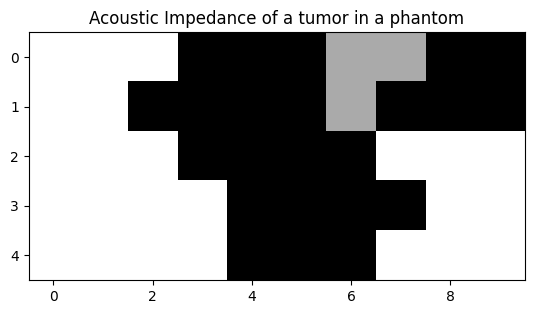

Text(0.5, 1.0, 'Reflection Coefficients of a tumor in a phantom')

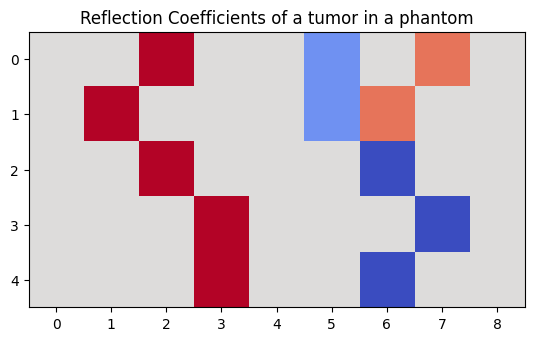

In [6]:
r_tensor = torch.tensor([[1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.69e6,1.69e6,1.65e6,1.65e6,], 
                         [1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.65e6,1.69e6,1.65e6,1.65e6,1.65e6,],
                         [1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.65e6,1.71e6,1.71e6,1.71e6,],
                         [1.71e6,1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.65e6,1.71e6,1.71e6],
                         [1.71e6,1.71e6,1.71e6,1.71e6,1.65e6,1.65e6,1.65e6,1.71e6,1.71e6,1.71e6],])

plt.imshow(r_tensor, cmap='gray', interpolation='nearest')
plt.xticks()
plt.yticks()
plt.title("Acoustic Impedance of a tumor in a phantom")
plt.show()
tensor = UR.compute_reflection_coeff(r_tensor[:,1:], r_tensor[:,:-1])
# prop_single_ray(tensor.unsqueeze(0))
plt.imshow(tensor, cmap='coolwarm', interpolation='nearest')
plt.xticks()
plt.yticks()
plt.title("Reflection Coefficients of a tumor in a phantom"
          
          )


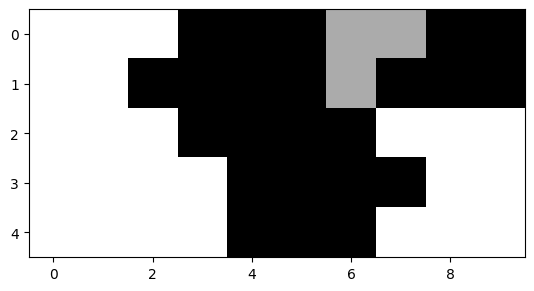

In [7]:
single_prop, _ = compute_echo_traces(tensor)
plt.imshow(single_prop, cmap='gray')
# plt.grid('on')

The plot above gives us a good idea of a mixed medium 2D slice, with a large structure and an inner substructure. This could be a tumor with a necrotic core, or a cyst with a solid part. The reflection coefficients are computed from the acoustic impedance tensor, which is a 2D representation of the medium's properties. The reflection coefficients are then used to compute the echo traces, which represent the reflected ultrasound waves.

However, this is not enough as having the impedance and reflection coefficients only means we know what happens at each stop, not for a global echo. To solve this, we convolve a signal with the resulting echo traces. This allows us to have a more realistic representation of the echo parsing through the membrane and returning to the start point.

The gaussian parameters (length/width) control for the precision of the resulting convolution. A width of 1 makes for the sharpest (voxel-sharp) image, while larger widths will lead to worse results.

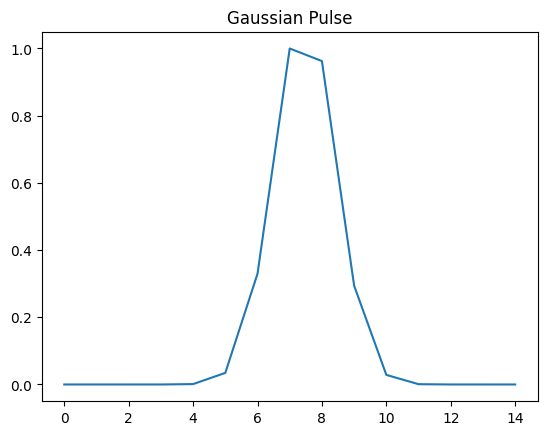

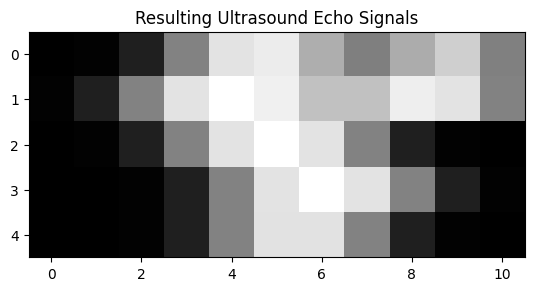

In [8]:
pulse = gaussian_pulse(15, 1)
pulse = torch.tensor(pulse, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
plt.plot(pulse[0, 0].numpy())
plt.title("Gaussian Pulse")
plt.show()
echo_signals = compute_gaussian_pulse(tensor)

plt.imshow(-echo_signals.squeeze(1), cmap='gray')
plt.title("Resulting Ultrasound Echo Signals");

# Recap the results

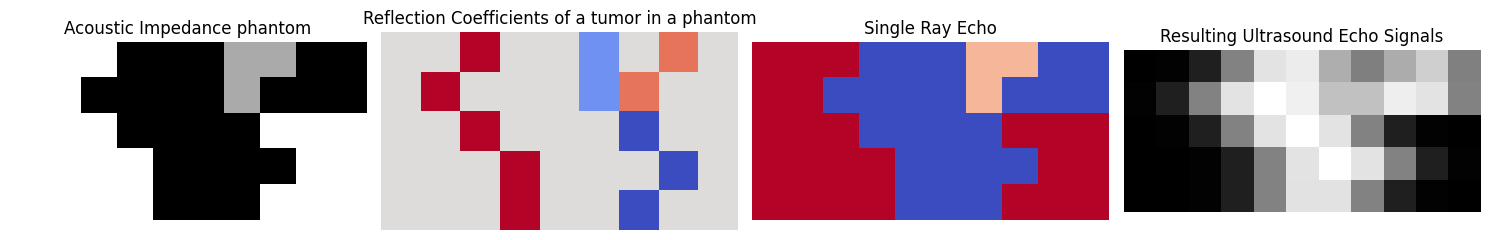

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

img_legend = [[r_tensor, "Acoustic Impedance phantom", 'gray'],
              [tensor, "Reflection Coefficients of a tumor in a phantom", 'coolwarm'],
              [single_prop, "Single Ray Echo", 'coolwarm'],
              [-echo_signals.squeeze(1), "Resulting Ultrasound Echo Signals", 'gray']]

for i, (img, title, cmap) in enumerate(img_legend):
    ax[i].imshow(img, cmap=cmap, interpolation='nearest')
    ax[i].set_title(title)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

Some thoughts here: the general issue is that while a _stable_ ray propagation is nicely obtained using our matrix formula, ray propagation consists of invoking a propagated signal. This means that we don't want an stable but a pulse run through. However, rays normally have rebounds contributing to the total echo. This means there is some part of n-th rebounds that conrtibutes to the resulting echo signals. Thus, using the stable results for the echo computation allows to approximate this rebound stability. We then convolce with a gaussian signal to simulate the passthrough of a signal.

# Applying to real MRI

In [10]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"

# Load with nibabel; each img is a Nifti1Image object
us_img = nib.load(str(image_path / iUS_file))
t1_img = nib.load(str(image_path / t1_file))
t2_img = nib.load(str(image_path / t2_file))

# Extract data arrays (as NumPy) and affines
US_vol = us_img.get_fdata(dtype=np.float32)
US_affine = us_img.affine
T1_vol = t1_img.get_fdata(dtype=np.float32)
T1_affine = t1_img.affine
T2_vol = t2_img.get_fdata(dtype=np.float32)
T2_affine = t2_img.affine

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# =====================
# Academic Plot Settings
# =====================
plt.style.use('seaborn-v0_8-paper')
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Palatino', 'DejaVu Serif'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'axes.linewidth': 1.2,
    'grid.color': '0.8',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'figure.figsize': (7, 5),
    'figure.autolayout': True,
    'mathtext.fontset': 'stix'
})

# =====================
# MLP Model Definition
# =====================
class ImpedanceEstimator(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)
    
    @staticmethod
    def train_model(X, y, input_dim=1, epochs=2000, lr=0.01):
        model = ImpedanceEstimator(input_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            if (epoch+1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4e}')
                
        return model

# =====================
# Prepare Data
# =====================
# Tissue characteristics data
tissue_data = pd.DataFrame({
    "Tissue": ["Fat", "Liver", "Muscle", "White Matter", "Gray Matter", "CSF", "Air"],
    "T1 Intensity": [260, 500, 870, 780, 920, 2500, 0],
    "Impedance (MRayl)": [1.34, 1.67, 1.68, 1.60, 1.60, 1.50, 0.0004]
})

# Normalize intensities to [0, 1] range
min_int, max_int = tissue_data['T1 Intensity'].min(), tissue_data['T1 Intensity'].max()
tissue_data['Norm Intensity'] = (tissue_data['T1 Intensity'] - min_int) / (max_int - min_int)

# Create training tensors
X_train = torch.tensor(tissue_data['Norm Intensity'].values.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(tissue_data['Impedance (MRayl)'].values.reshape(-1, 1), dtype=torch.float32)

# Train model
print("Training MLP model...")
model = ImpedanceEstimator.train_model(X_train, y_train)
print("Training complete!")

# =====================
# Generate Prediction Curve
# =====================
x_range = np.linspace(-0.1, 1.1, 500)
x_tensor = torch.tensor(x_range, dtype=torch.float32).view(-1, 1)
with torch.no_grad():
    y_pred = model(x_tensor).numpy().flatten()



Training MLP model...
Epoch [500/2000], Loss: 6.6068e-04
Epoch [1000/2000], Loss: 6.6068e-04
Epoch [1500/2000], Loss: 6.6068e-04
Epoch [2000/2000], Loss: 6.6068e-04
Training complete!


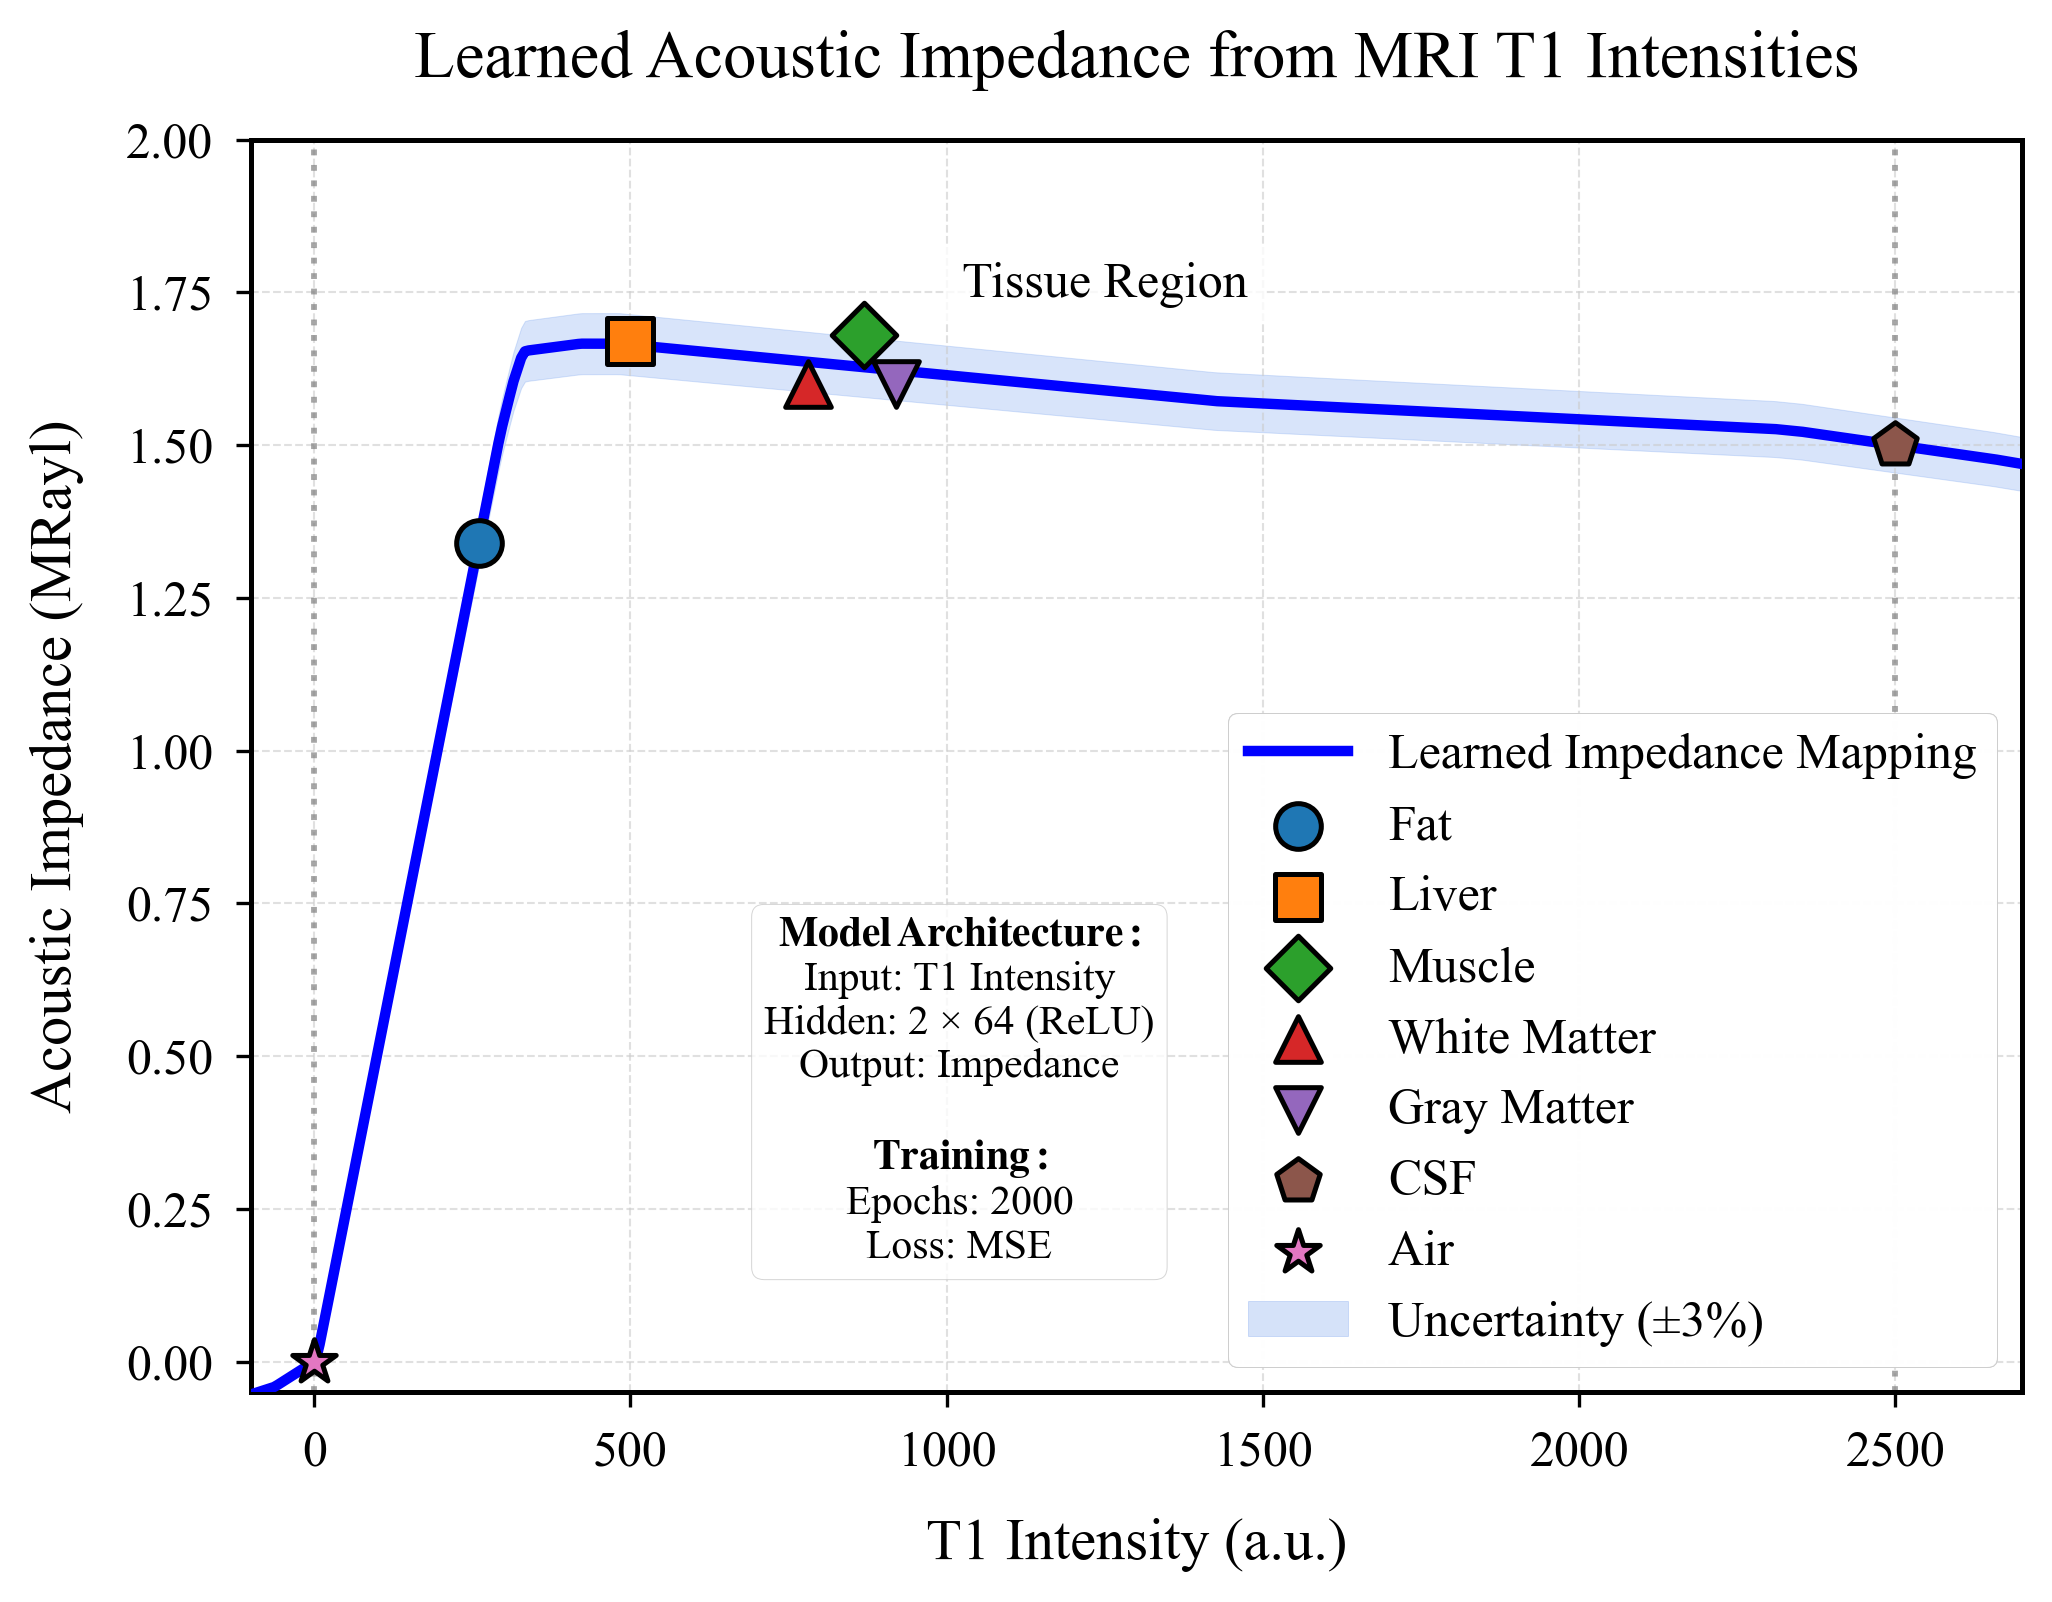

In [65]:
# =====================
# Create Academic Plot (using original intensities)
# =====================
fig, ax = plt.subplots(figsize=(7, 5.5))

# Convert normalized range back to original intensities
x_curve_original = min_int + (x_range) * (max_int - min_int)

# Plot learned mapping using original intensities
ax.plot(x_curve_original, y_pred, 'b-', linewidth=2.5, 
        label='Learned Impedance Mapping', zorder=10)

# Plot training points using original intensities
markers = ['o', 's', 'D', '^', 'v', 'p', '*']
colors = plt.cm.tab10.colors[:len(tissue_data)]

for i, (_, row) in enumerate(tissue_data.iterrows()):
    ax.scatter(row['T1 Intensity'], row['Impedance (MRayl)'], 
               s=120, marker=markers[i], color=colors[i],
               edgecolor='k', linewidth=1.2, 
               label=row['Tissue'], zorder=20)

# Add uncertainty region using original intensities
ax.fill_between(x_curve_original, y_pred * 0.97, y_pred * 1.03, 
                color='cornflowerblue', alpha=0.25,
                label='Uncertainty (±3%)')

# Add vertical lines for key regions in original space
ax.axvline(x=min_int, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=max_int, color='gray', linestyle=':', alpha=0.7)

# Set labels and title
ax.set_xlabel('T1 Intensity (a.u.)', fontsize=14, labelpad=10)
ax.set_ylabel('Acoustic Impedance (MRayl)', fontsize=14, labelpad=10)
ax.set_title('Learned Acoustic Impedance from MRI T1 Intensities', 
             fontsize=16, pad=15)

# Set axis limits and ticks
ax.set_xlim(-100, 2700)
ax.set_ylim(-0.05, 2.0)
ax.set_xticks(np.arange(0, 2600, 500))
ax.set_yticks(np.arange(0.0, 2.1, 0.25))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Create and position main legend (top-right)
main_legend = ax.legend(loc='lower right', framealpha=0.92, 
                        fancybox=True, shadow=False, ncol=1)
ax.add_artist(main_legend)  # Explicitly add to axes

# Create simplified legend for model elements (top-left)
from matplotlib.lines import Line2D
model_lines = [
    Line2D([0], [0], color='b', lw=2.5, label='Learned Mapping'),
    Line2D([0], [0], color='cornflowerblue', alpha=0.25, 
           label='Uncertainty (±3%)', linewidth=10)
]
# model_legend = ax.legend(handles=model_lines, loc='upper left', 
#                          framealpha=0.92, title='Model Elements',
#                          title_fontsize=12)
# ax.add_artist(model_legend)  # Explicitly add to axes

# Add textbox with model info (bottom-left)
model_info = (
    r"$\bf{Model\,Architecture:}$" "\n"
    "Input: T1 Intensity\n"
    "Hidden: 2 × 64 (ReLU)\n"
    "Output: Impedance\n\n"
    r"$\bf{Training:}$" "\n"
    "Epochs: 2000\n"
    "Loss: MSE"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='0.8')
ax.text(0.4, 0.1, model_info, transform=ax.transAxes, 
        fontsize=10, horizontalalignment="center" ,verticalalignment='bottom', bbox=props)

# Add domain annotations
# ax.text(min_int+50, -0.1, 'Min Intensity', ha='left', va='top', 
#         fontsize=10, color='gray')
# ax.text(max_int-50, -0.1, 'Max Intensity', ha='right', va='top', 
#         fontsize=10, color='gray')
ax.text((min_int+max_int)/2, 1.8, 'Tissue Region', ha='center', va='top', 
        fontsize=12, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Save in multiple formats
plt.savefig('impedance_mapping.pdf', bbox_inches='tight')
plt.savefig('impedance_mapping.tiff', dpi=600, format='tiff', bbox_inches='tight')
plt.savefig('impedance_mapping.png', dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [66]:
to_forward = torch.tensor(T1_vol).unsqueeze(-1)
# Normalize T1_vol to [0, 1] using min_int and max_int from training
T1_norm = (torch.tensor(T1_vol, dtype=torch.float32) - min_int) / (max_int - min_int)
T1_norm = T1_norm.clamp(0, 1)  # Clamp to [0, 1] to avoid out-of-range

# Feed to model slice by slice and store in correct orientation
predicted_impedances = torch.empty_like(T1_norm)
with torch.no_grad():
    for i in range(T1_norm.shape[2]):
        slice_data = T1_norm[:, :, i].unsqueeze(-1)
        pred = model(slice_data)
        predicted_impedances[:, :, i] = pred.squeeze(-1)

# Now predicted_impedances has the same shape and orientation as T1_vol
Z_vol = predicted_impedances.numpy()


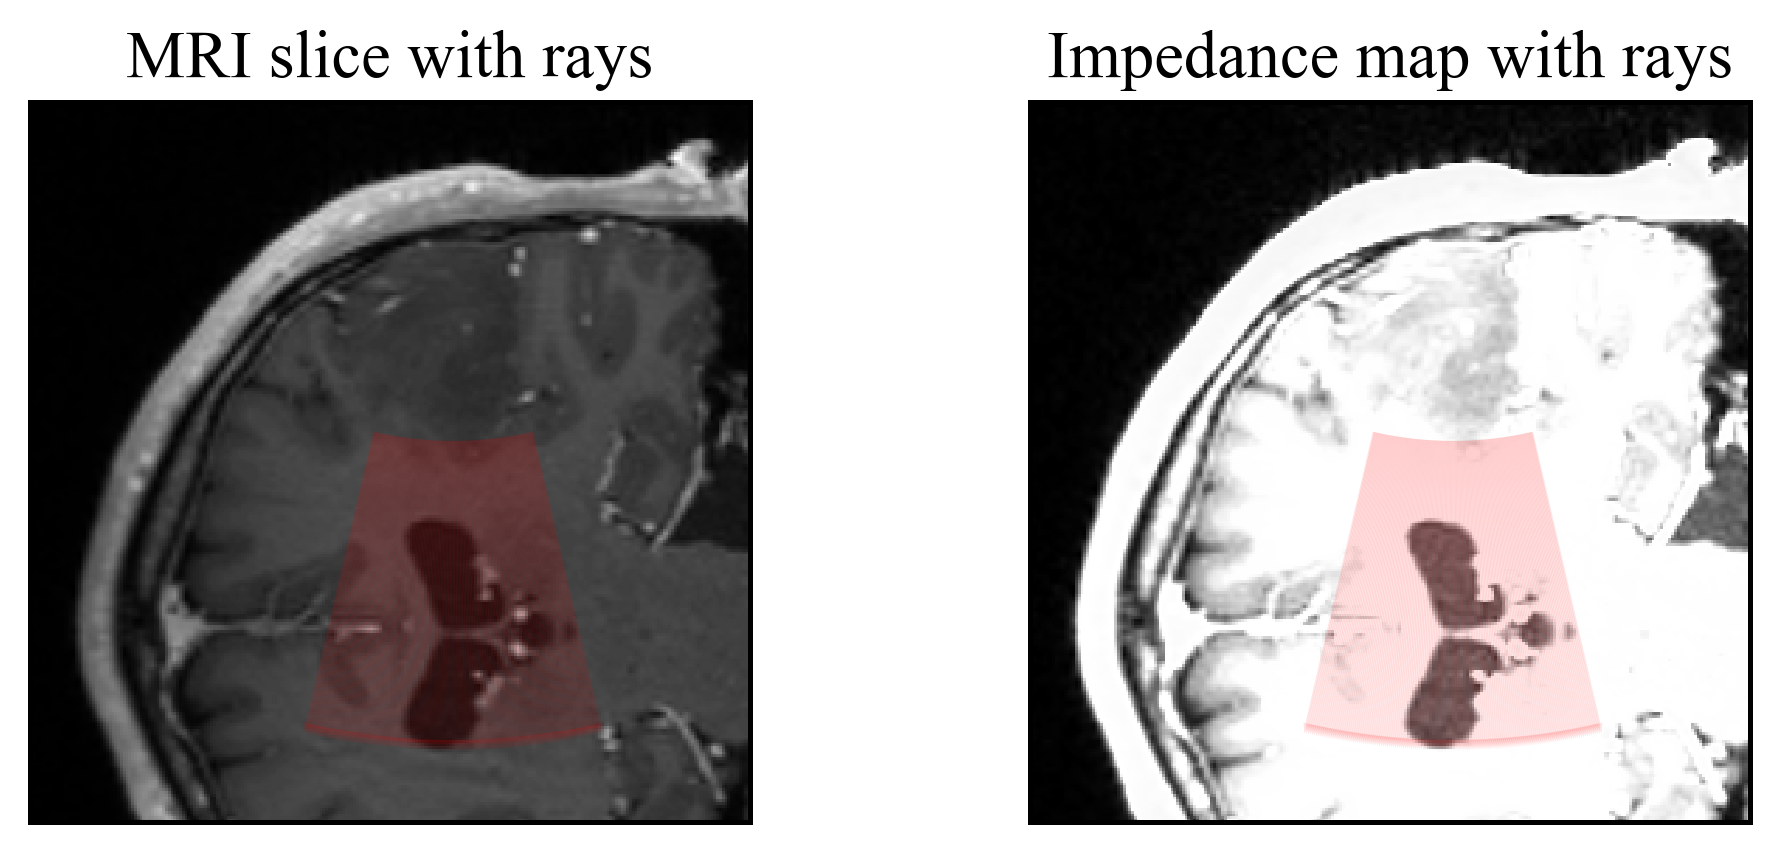

In [68]:
UR = UltrasoundRenderer(220, 0.0001)

angle = 27//2  # degrees
rays = 150

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
source = np.array([260, 100, 150])  # source position
directions = [np.array([-np.cos(theta), 0, np.sin(theta)]) for theta in thetas]
directions = torch.tensor(directions, dtype=torch.float32)  # (rays, 3)

start = 0.5 # offset in pixels (or in image units depending on scaling)

N = directions.shape[0]

# Ray directions in image space: z becomes x-axis, x becomes y-axis
dz = directions[:, 2].numpy()  # z → image x
dx = directions[:, 0].numpy()  # x → image y

# Compute shifted start points along ray direction
starts_x = source[2] + start *250* dz  # z (→ x in image)
starts_y = source[0] + start *250* dx  # x (→ y in image)

# Plot frame and arrows for MRI
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# MRI slice with rays
img = T1_vol[:, source[1], :].T  # image = (z, x)
ax0 = axes[0]
ax0.imshow(img.T, cmap='gray', interpolation='nearest', origin='lower')
ax0.quiver(
    starts_x, starts_y,
    dz * (1-start), dx*(1-start),
    angles='xy', scale_units='xy', scale=1/UR.num_samples,
    color='red', width=0.003, alpha=0.1
)
ax0.set_title("MRI slice with rays")
ax0.set_xticks([])
ax0.set_yticks([])

# Impedance map with rays
ax1 = axes[1]
ax1.imshow(Z_vol[:, source[1], :], cmap='gray', interpolation='nearest', origin='lower')
ax1.quiver(
    starts_x, starts_y,
    dz*(1-start), dx*(1-start),
    angles='xy', scale_units='xy', scale=1/UR.num_samples,
    color='red', width=0.003, alpha=0.1
)
ax1.set_title("Impedance map with rays")
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()
# plt.show()

[INFO] Tracing rays with source: tensor([260, 100, 150]) and directions shape: torch.Size([150, 1, 3])
[INFO] Visualizing sampled points in 3D volume
[INFO] Variances: x=3948.3413, y=0.0000, z=275.8368


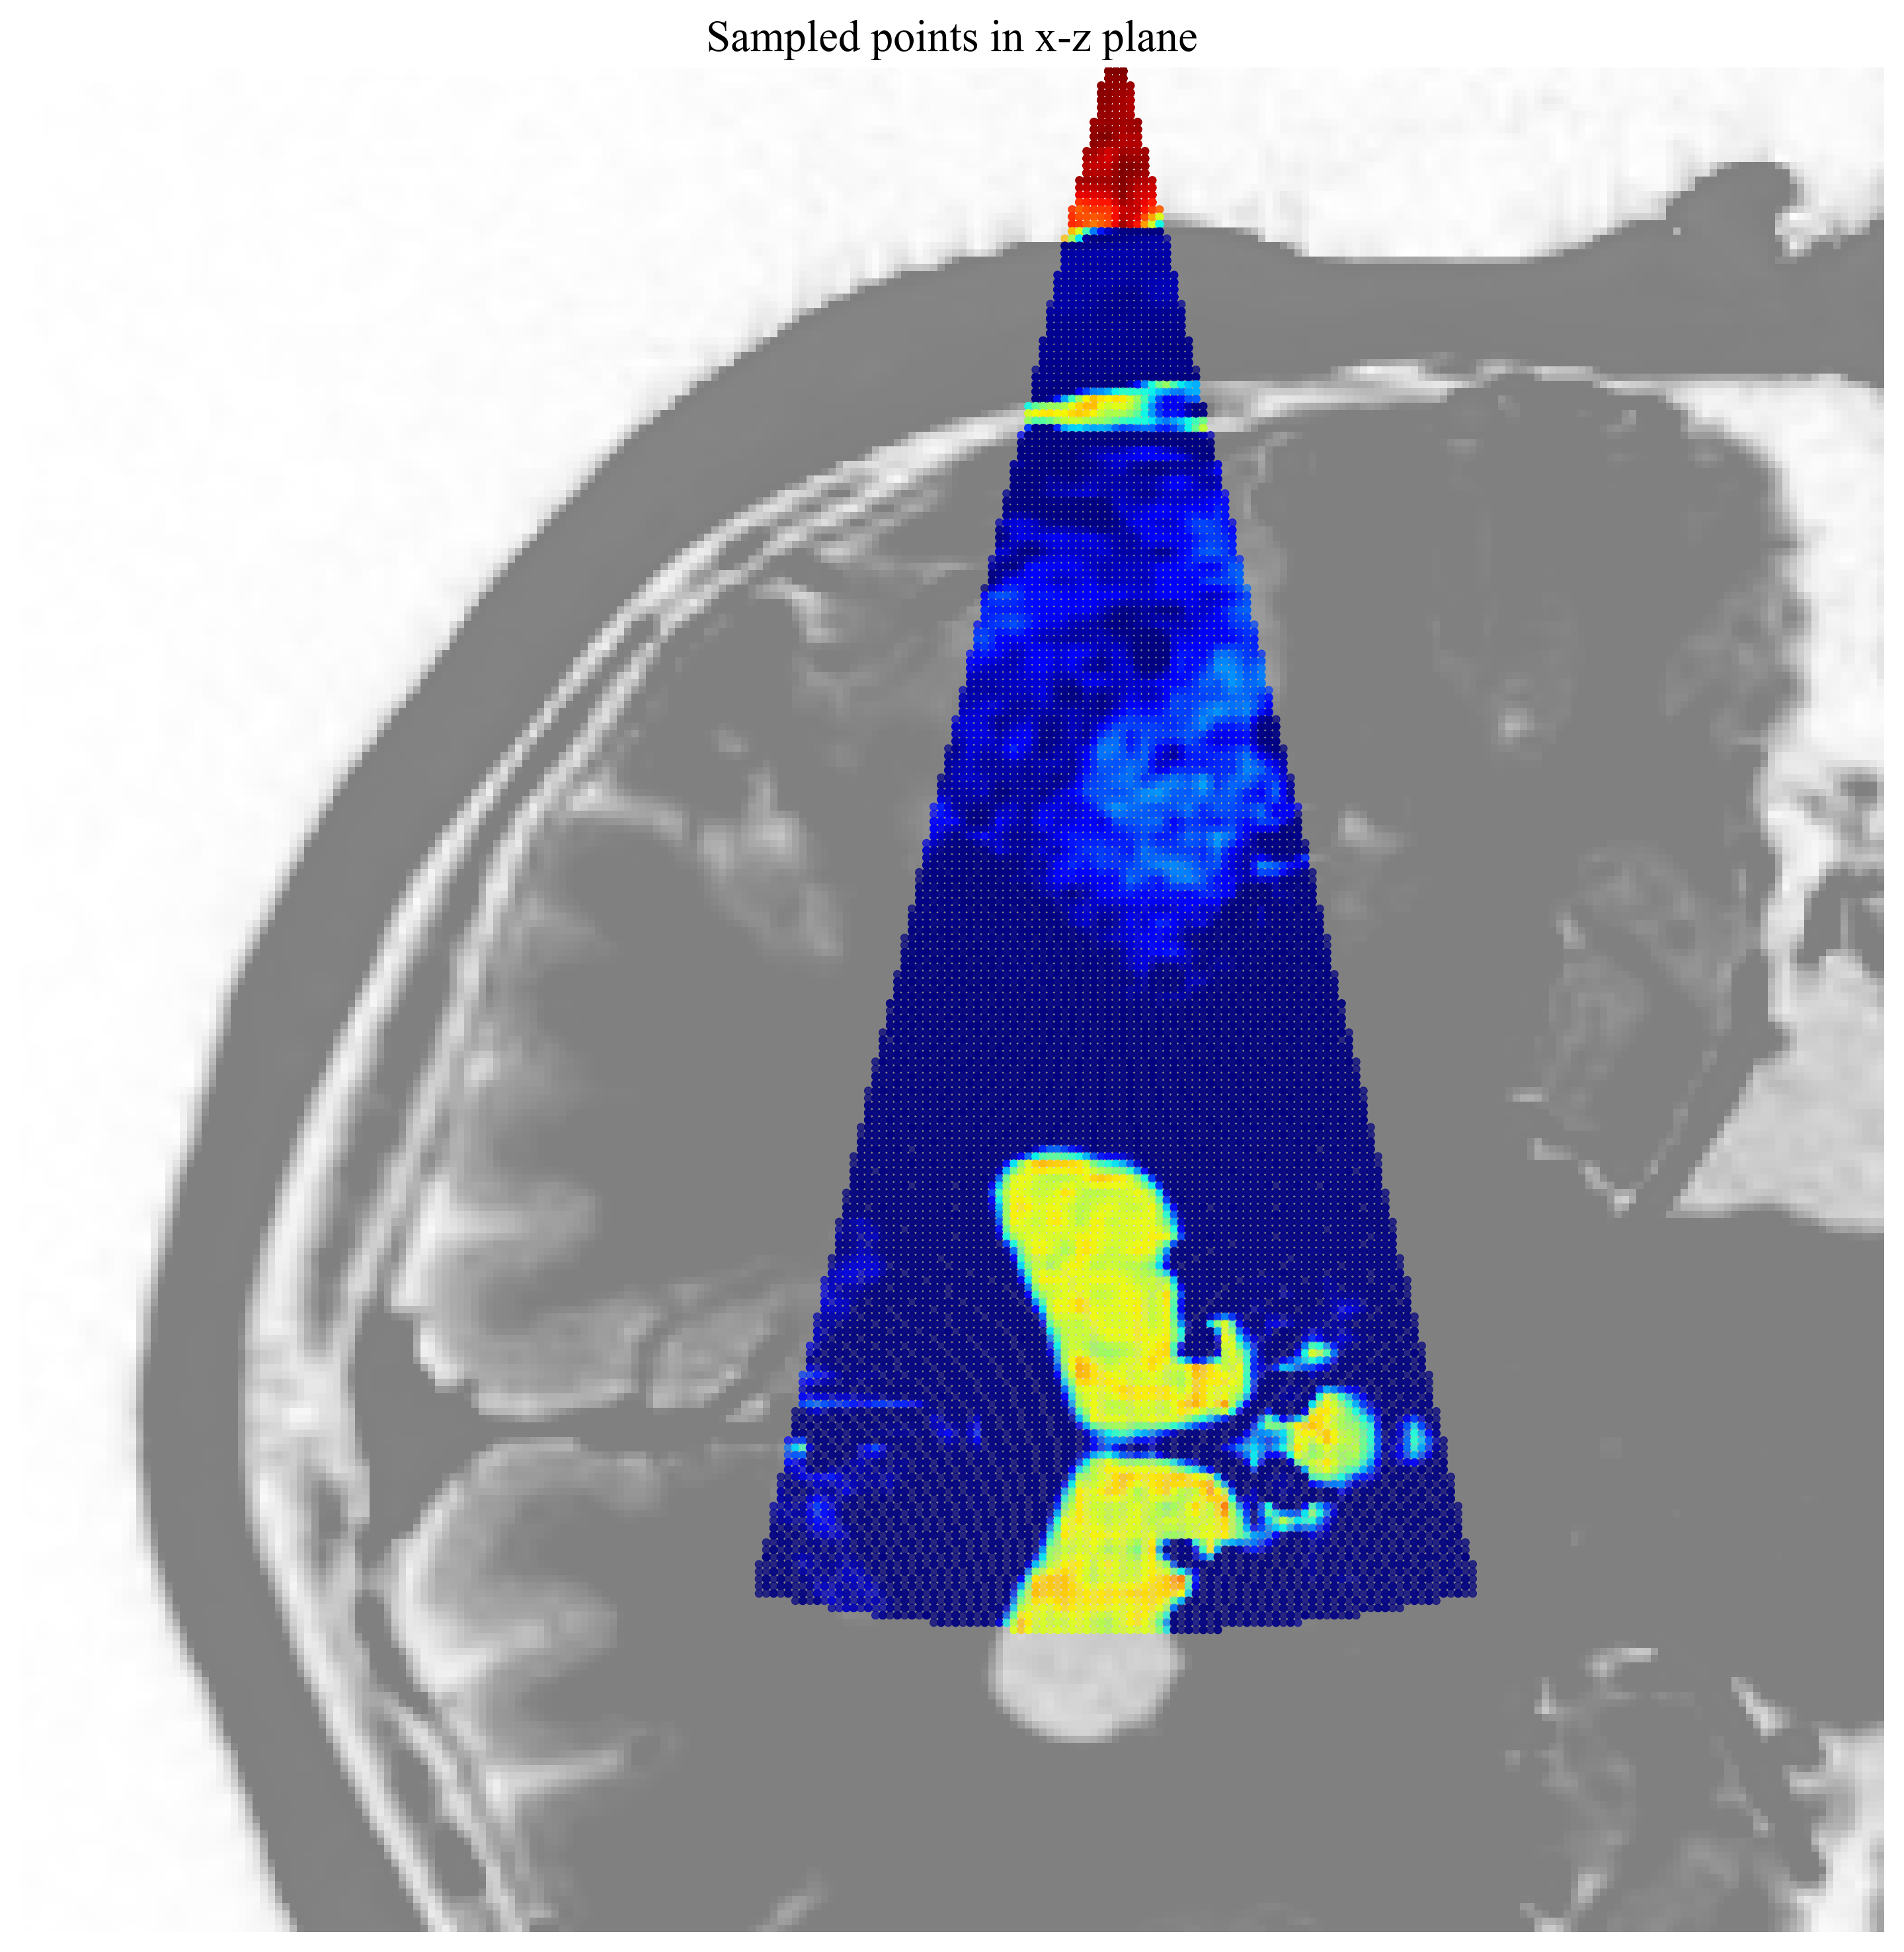

[INFO] Ray values shape: torch.Size([150, 220])
[INFO] Starting from sample index: 70 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 70 torch.Size([150, 220])
[INFO] Variances: [1843.769775390625, 0.0, 391.69793701171875]
tensor(-9.3872) tensor(24.4100) tensor(0.1154)


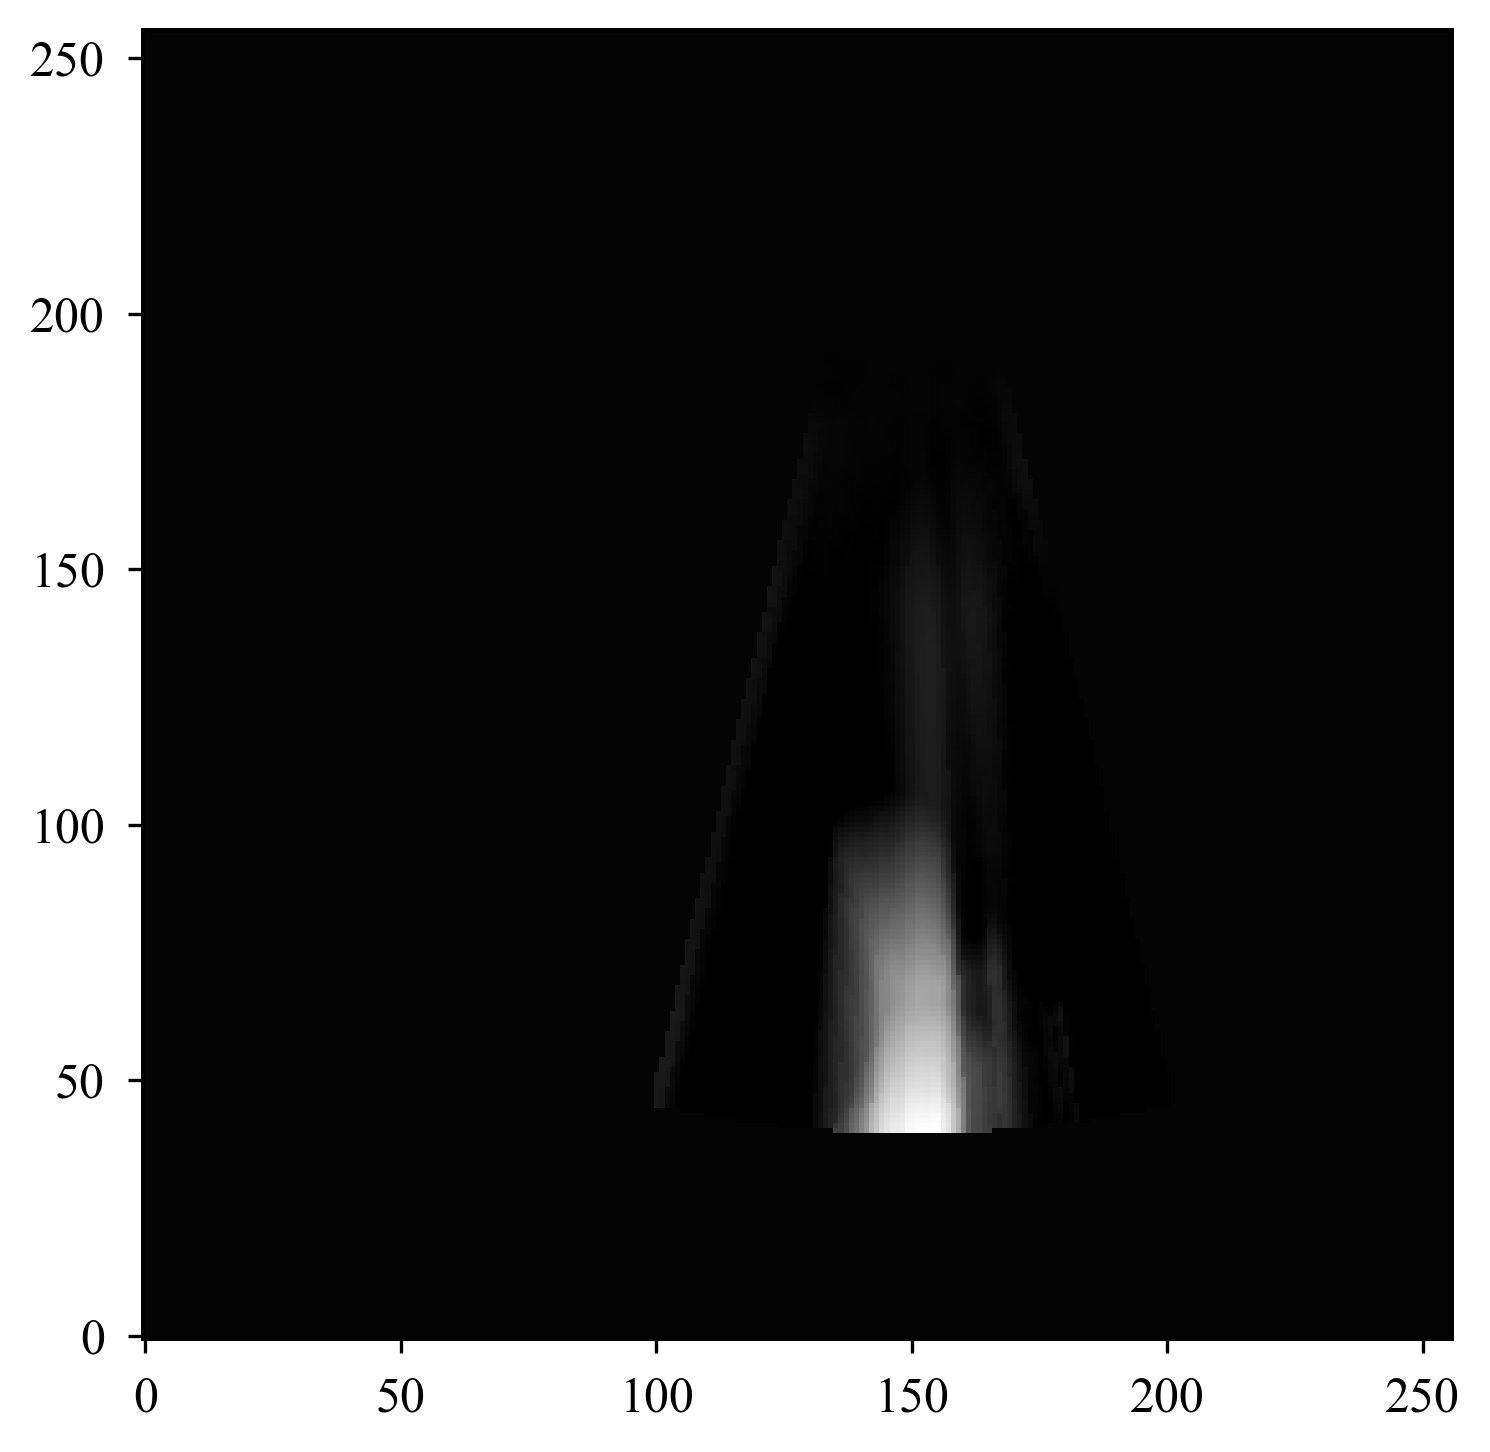

In [146]:
x,y, z,intensities = UR.plot_beam_frame(
    volume=-torch.tensor(Z_vol),
    source=torch.tensor(source),
    directions=directions,
    artifacts=False,
    angle=2*angle,
    start=70,
)
synth_img = differentiable_splat(x,y,z, intensities, H=256, W=256, sigma=0.5)
print(synth_img.min(), synth_img.max(), synth_img.mean())
plt.imshow(synth_img, cmap='gray', origin="lower", vmin=-0.4)

## Comparing to the US files

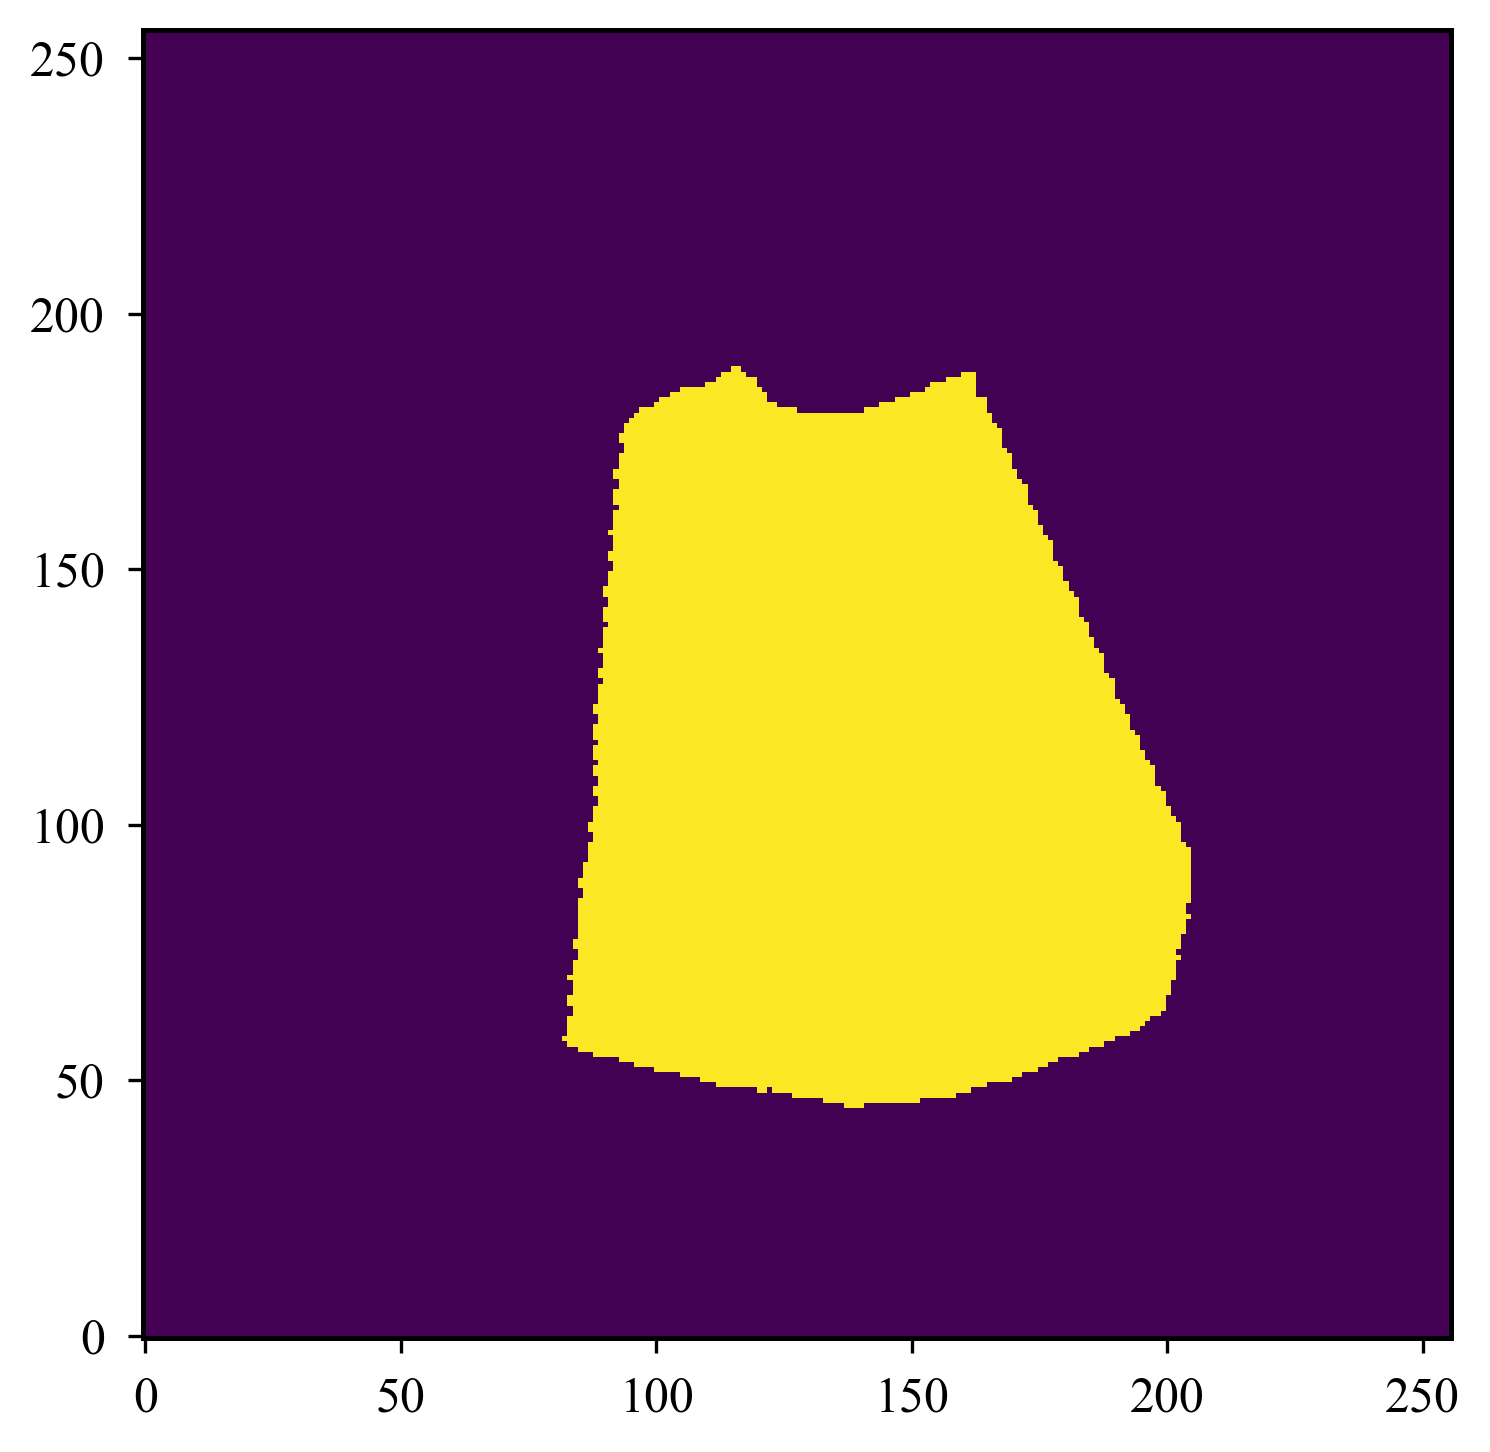

In [110]:

plt.imshow(US_vol[:, source[1], :]>0., origin='lower') # to select the important region

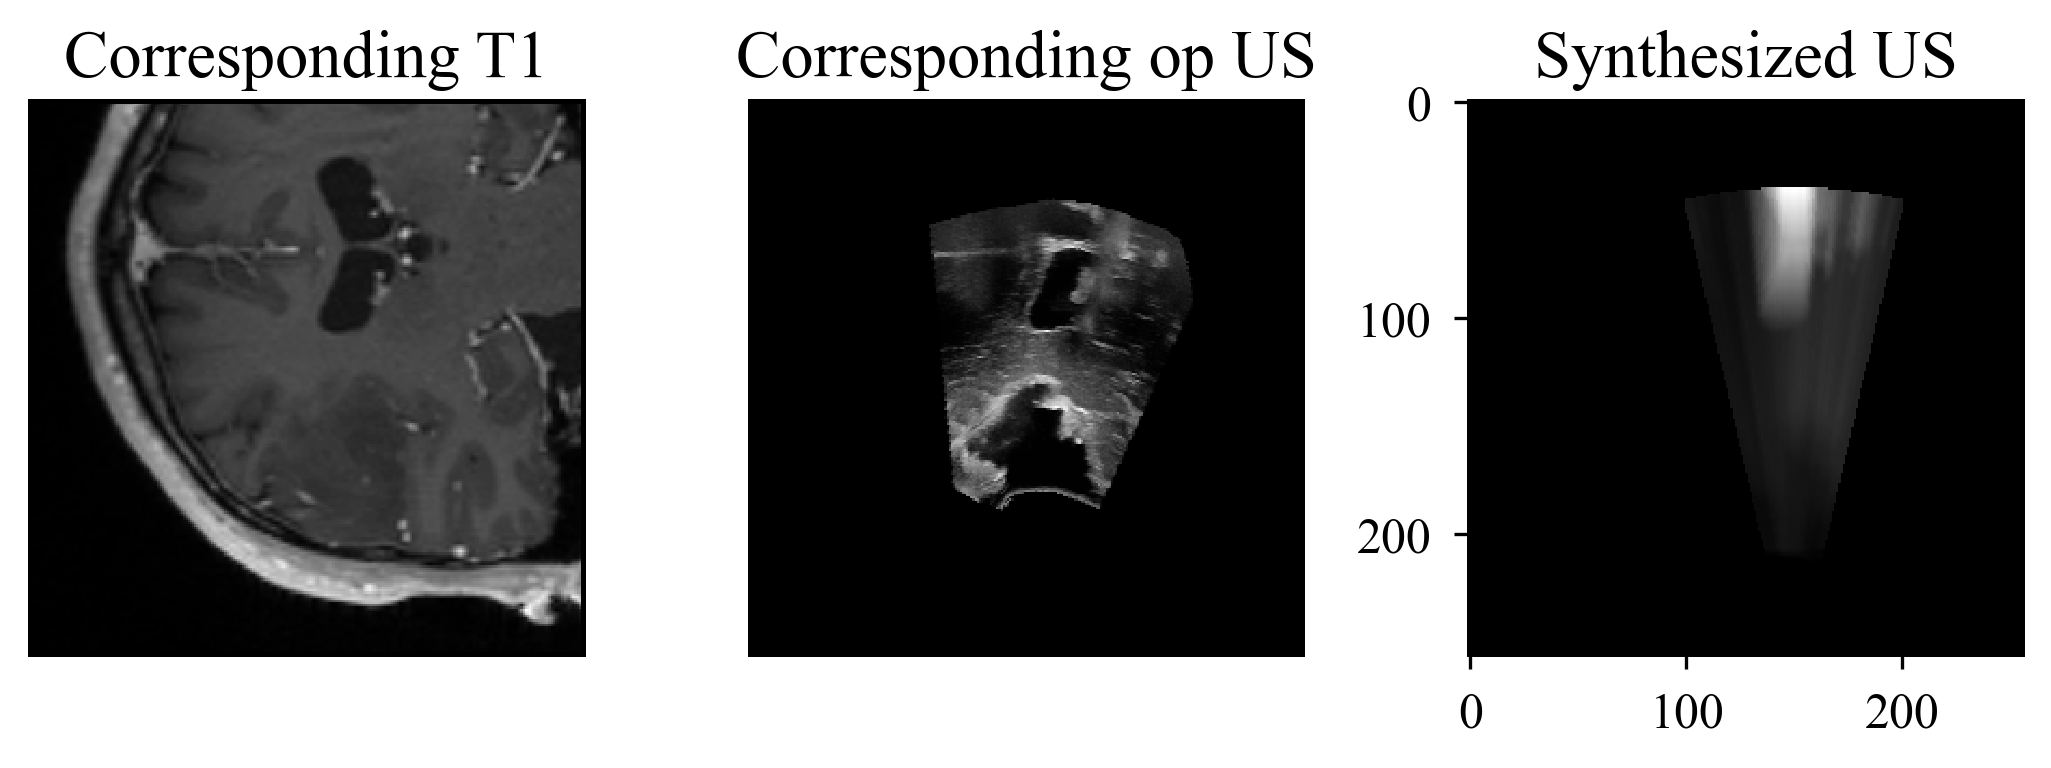

In [122]:
fig, ax = plt.subplots(1,3)

# change contrast
ax[0].imshow(T1_vol[:, source[1], :], cmap='gray', interpolation='nearest', alpha=1)
ax[0].set_title("Corresponding T1")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(US_vol[:, source[1], :], cmap='gray', interpolation='nearest', alpha=1)
ax[1].set_title("Corresponding op US")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(synth_img, cmap='gray', interpolation='nearest', alpha=1)
ax[2].set_title("Synthesized US")
plt.show()

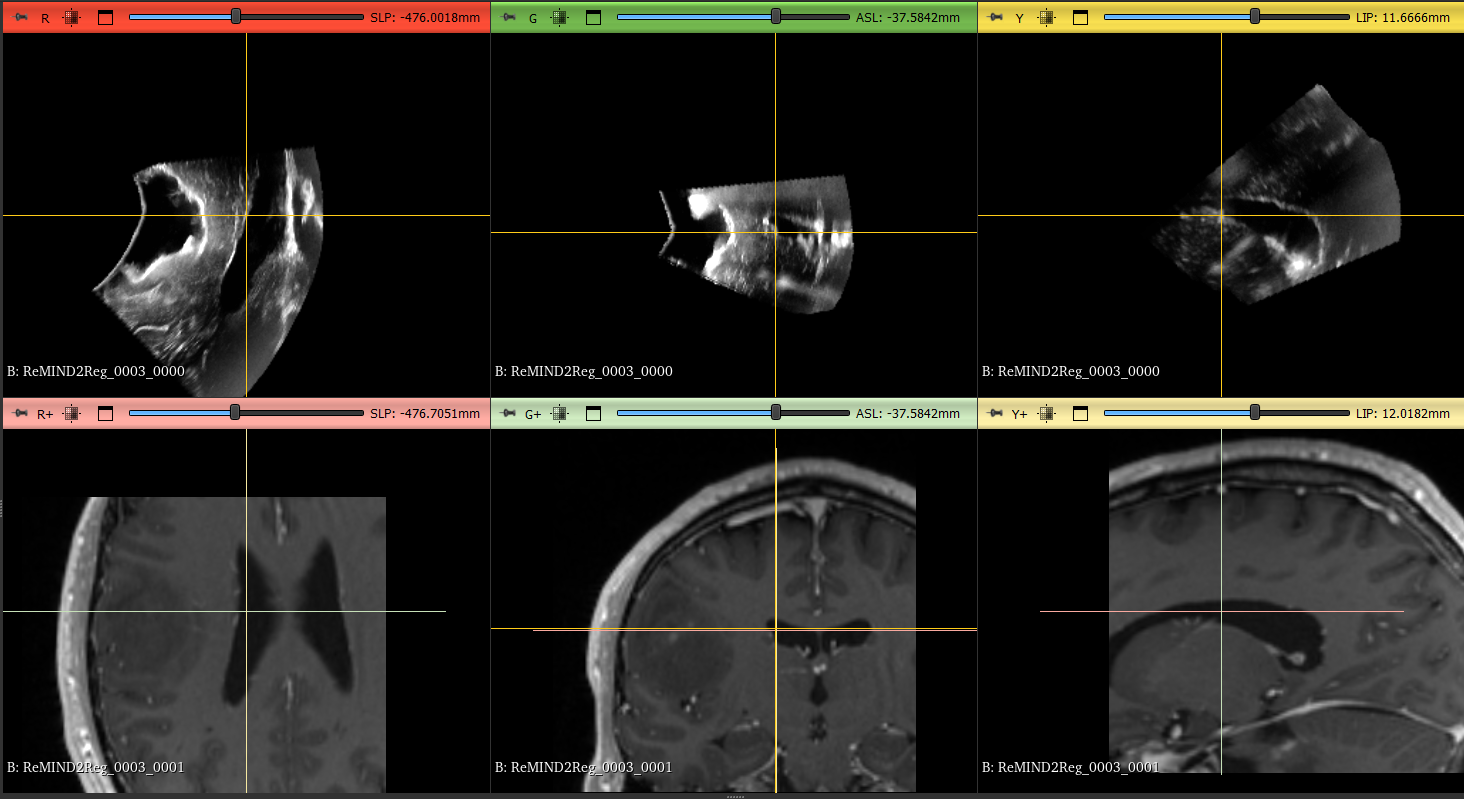

Here is the aligned US/MRI from whithin Slicer.